In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm
import os
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from skimage import io
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2

In [2]:
#Controllo che torch sia installato con CUDA abilitato
def check_cuda():
    print(torch.version.cuda)
    cuda_is_ok = torch.cuda.is_available()
    print(f"CUDA Enabled: {cuda_is_ok}")

In [3]:
print(torch.version.cuda)

11.7


In [4]:
model_weights = False

In [5]:
#Directory per i file di train
DATA_DIR = ''

#Grandezza del Batch (iperparametro)
BATCH_SIZE = 32

#Learning Rate (Iperparametro)
LR = 0.001

#Numero di epoche (Iperparametro)
EPOCHS = 80

DEVICE = 'cuda'

In [6]:
# Carica il file csv
df_real = pd.read_csv("real_image_dataset.csv")

df_fake = pd.read_csv("fake_image_dataset.csv")

train_df_real, valid_df_real = train_test_split(df_real, test_size = 0.20, random_state = 42)
train_df_fake, valid_df_fake = train_test_split(df_fake, test_size = 0.20, random_state = 42)

test_df_real = train_df_real.sample(500)
test_df_fake = train_df_fake.sample(500)
train_df_real = train_df_real.drop(test_df_real.index)
train_df_fake = train_df_fake.drop(test_df_fake.index)

train_df = pd.concat([train_df_real, train_df_fake])
valid_df = pd.concat([valid_df_real, valid_df_fake])
test_df = pd.concat([test_df_real, test_df_fake])

train_df= train_df.sample(frac= 1)
valid_df= valid_df.sample(frac= 1)

# Unisci tutti i dataframe in un unico dataframe finale per il train set
final_df = pd.concat([train_df, valid_df])

# Salva il dataframe finale di trian in un file CSV
final_df.to_csv("spectrum_train_dataset.csv", index=False)
df = pd.read_csv("spectrum_train_dataset.csv")

# Concatenare le colonne 'Anchor', 'Positive', e 'Negative' e selezionare 500 immagini
#real_images = pd.concat([test_df_real['Anchor'], test_df_real['Positive']]).sample(500, random_state=42).values
#fake_images = pd.concat([test_df_fake['Anchor'], test_df_fake['Positive']]).sample(500, random_state=42).values

# Crea una lista combinata con 500 immagini false seguite da 500 immagini reali
#combined_images = list(fake_images) + list(real_images)

# Crea il dataframe del test set con una sola colonna
#test_df = pd.DataFrame(combined_images, columns=[''])

# Salva il dataframe del test set in un file CSV
#test_df.to_csv("test_set.csv", index=False, header=False)

print('Size of train set:', len(train_df))
print('Size of valid set:', len(valid_df))
print('Size of test set:', len(test_df))

Size of train set: 15000
Size of valid set: 4000
Size of test set: 1000


In [7]:
# Carico le immagini del file CSV che ho fornito, per settarle in modo corretto e darle in input alla rete neurale
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor, as_gray= True)
    P_img = io.imread(DATA_DIR + row.Positive, as_gray= True)
    N_img = io.imread(DATA_DIR + row.Negative, as_gray= True)

    
    #Permute because the third channel has to be in first channel in torch
    A_img = np.expand_dims(A_img, 0)
    P_img = np.expand_dims(P_img, 0)
    N_img = np.expand_dims(N_img, 0)

    A_img = torch.from_numpy(A_img)/ 255.0
    P_img = torch.from_numpy(P_img)/ 255.0
    N_img = torch.from_numpy(N_img)/ 255.0
      
    #A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
    #P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
    #N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

    return A_img, P_img, N_img

In [8]:
data = APN_Dataset(train_df)
item1, item2, item3 = data.__getitem__(0)
print(item1.shape)

torch.Size([1, 200, 200])


Qui di seguito mi stampo il numero che compone l'insieme di dati di train, test e validation

In [9]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)
testset = APN_Dataset(test_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")
print(f"Size of validset: {len(testset)}")

Size of trainset: 15000
Size of validset: 4000
Size of validset: 1000


Carichiamo i dati di train e validation nella batch

In [10]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)
testloader = DataLoader(testset, batch_size = 1)

In [11]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")
print(f"No. of batches in testloader : {len(testloader)}")

No. of batches in trainloader : 469
No. of batches in validloader : 125
No. of batches in testloader : 1000


Questa funzione definisce un modello di rete neurale chiamato APN_Model, che carica un'architettura di rete preaddestrata e sostituisce il classificatore finale con un nuovo classificatore personalizzato.

In [12]:
#Carico il modello di rete neurale
class APN_Model(nn.Module):

    #Viene definita la size del vettore di embedding
  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    #QUI CAIRCATE IL MODELLO, IN QUESTO CASO EFFICIENTNET VERSIONE B0 (LA PIù LEGGERA DELLA FAMIGLIA)
    self.efficientnet = timm.create_model('tf_efficientnetv2_b0', pretrained = False)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [13]:
#QUI FATE UNA PICCOLA MODIFICA ALLA RETE PER FARLE AVERE IN INPUT IMMAGINI IN SCALA DI GRIGIO DELLO SPETTRO DI FOURIER
model = APN_Model()
model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False);

if model_weights == True :
    model.load_state_dict(torch.load('trained_model_on_20000.pt'))

model.to(DEVICE);

In [14]:
#FUNZIONE DI TEST
def test_fn(model, dataloader, criterion):
  model.train() #ON Dropout
  total_loss = 0.0

  with torch.no_grad():  
    for A, P, N in tqdm(dataloader):
        A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)
      
        loss = criterion(A_embs, P_embs, N_embs)
      
        total_loss += loss.item()

    return total_loss / len(dataloader)

In [18]:
#FUNZIONE DI TRAINING
def train_fn(model, dataloader, optimizer, criterion):
  model.train() #ON Dropout
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [19]:
#FUNZIONE DI EVALUATION
def eval_fn(model, dataloader, criterion):
  model.eval() #OFF Dropout
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [20]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [21]:
#Training
if model_weights == False :
    best_valid_loss = np.Inf
    training_loss = []
    validation_loss = []
    for i in range(EPOCHS):
      train_loss = train_fn(model, trainloader, optimizer, criterion)
      valid_loss = eval_fn(model, validloader, criterion)
      training_loss.append(train_loss)
      validation_loss.append(valid_loss)

      if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'trained_model_on_20000.pt')
        best_valid_loss = valid_loss
        print("SAVED_WEIGHTS_SUCCESS")

      print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")

100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.48it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 1 train_loss : 0.32421021086416013 valid_loss : 0.12768796581029893


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.70it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 2 train_loss : 0.11748186426201482 valid_loss : 0.10730799704790116


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.81it/s]


EPOCHS : 3 train_loss : 0.123261616908824 valid_loss : 0.17365581318736076


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.69it/s]


EPOCHS : 4 train_loss : 0.0767302912777103 valid_loss : 0.11029963754117489


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.64it/s]


EPOCHS : 5 train_loss : 0.10470235051670626 valid_loss : 0.14833677046000956


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.68it/s]


EPOCHS : 6 train_loss : 0.0765226347002584 valid_loss : 0.17792710672318934


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.66it/s]


EPOCHS : 7 train_loss : 0.09139614301259076 valid_loss : 0.34165491683781146


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.69it/s]


EPOCHS : 8 train_loss : 0.07233530633659886 valid_loss : 0.1868608967512846


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.69it/s]


EPOCHS : 9 train_loss : 0.07894160535766372 valid_loss : 0.12923062038421632


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.69it/s]


EPOCHS : 10 train_loss : 0.058841875660965944 valid_loss : 0.25957181237637994


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.69it/s]


EPOCHS : 11 train_loss : 0.07128089934841657 valid_loss : 0.1267746641933918


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.69it/s]


EPOCHS : 12 train_loss : 0.08061780425499497 valid_loss : 0.1461478306800127


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.70it/s]


EPOCHS : 13 train_loss : 0.08524316420623743 valid_loss : 0.16026433336734772


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.75it/s]


EPOCHS : 14 train_loss : 0.05498331276846847 valid_loss : 0.12336392384767532


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.67it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 15 train_loss : 0.05599717153256128 valid_loss : 0.10403204597532749


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.65it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 16 train_loss : 0.04672332496038759 valid_loss : 0.09307198229432107


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.71it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 17 train_loss : 0.05544073198602271 valid_loss : 0.09102707329392433


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.66it/s]


EPOCHS : 18 train_loss : 0.042862507131403445 valid_loss : 0.09400167568027973


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.70it/s]


EPOCHS : 19 train_loss : 0.053815528863608075 valid_loss : 0.20782160088419915


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.71it/s]


EPOCHS : 20 train_loss : 0.05280790131674138 valid_loss : 0.0945105389803648


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.65it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 21 train_loss : 0.03327347125723037 valid_loss : 0.08550967459380626


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.70it/s]


EPOCHS : 22 train_loss : 0.05025239564430739 valid_loss : 0.17261509743332862


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.69it/s]


EPOCHS : 23 train_loss : 0.04563853717339573 valid_loss : 0.11863909915089607


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.68it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 24 train_loss : 0.0424394344787862 valid_loss : 0.0847934641391039


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.65it/s]


EPOCHS : 25 train_loss : 0.07239022257115077 valid_loss : 0.09212632502615452


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.68it/s]


EPOCHS : 26 train_loss : 0.034417275093130466 valid_loss : 0.10649411317706108


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.70it/s]


EPOCHS : 27 train_loss : 0.030412120943162233 valid_loss : 0.0943948479294777


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.66it/s]


EPOCHS : 28 train_loss : 0.027245627259458307 valid_loss : 0.11018978855013847


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.67it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 29 train_loss : 0.026005653350719256 valid_loss : 0.08414983697235584


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.69it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 30 train_loss : 0.020394633903400475 valid_loss : 0.08284969775378705


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.68it/s]


EPOCHS : 31 train_loss : 0.037197574417092906 valid_loss : 0.1044130028784275


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.70it/s]


EPOCHS : 32 train_loss : 0.029897694021209217 valid_loss : 0.09820085316896439


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.65it/s]


EPOCHS : 33 train_loss : 0.02869843247570971 valid_loss : 0.21973114429414273


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.68it/s]


EPOCHS : 34 train_loss : 0.03273070286681403 valid_loss : 0.11508942566812039


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.67it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 35 train_loss : 0.035686357554469285 valid_loss : 0.08063636310398578


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.65it/s]


EPOCHS : 36 train_loss : 0.026267738655400174 valid_loss : 0.08350346788764


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.66it/s]


EPOCHS : 37 train_loss : 0.01264399738469993 valid_loss : 0.0816058982014656


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.68it/s]


EPOCHS : 38 train_loss : 0.01962352927852008 valid_loss : 0.11073939873278141


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.65it/s]


EPOCHS : 39 train_loss : 0.02449110423578128 valid_loss : 0.08452500391006469


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.67it/s]


EPOCHS : 40 train_loss : 0.027637331986795865 valid_loss : 0.1071567133963108


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.73it/s]


EPOCHS : 41 train_loss : 0.031724114296659986 valid_loss : 0.16446321845054626


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.67it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 42 train_loss : 0.017976741395843054 valid_loss : 0.07464449980854988


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.69it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 43 train_loss : 0.02096751974875739 valid_loss : 0.07078612673282624


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.67it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 44 train_loss : 0.01723057660721004 valid_loss : 0.06786436736583709


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.71it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 45 train_loss : 0.01735802994036217 valid_loss : 0.06675710961222649


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.67it/s]


EPOCHS : 46 train_loss : 0.0396763594991871 valid_loss : 0.09101146411895752


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.69it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 47 train_loss : 0.017741877458560696 valid_loss : 0.06038212820887565


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.69it/s]


EPOCHS : 48 train_loss : 0.010082680501663355 valid_loss : 0.07097940504550934


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.68it/s]


EPOCHS : 49 train_loss : 0.012697472572644383 valid_loss : 0.07027344298362732


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.65it/s]


EPOCHS : 50 train_loss : 0.02441482384131153 valid_loss : 0.11079850727319718


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.66it/s]


EPOCHS : 51 train_loss : 0.015816052164286692 valid_loss : 0.06675802800059319


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.66it/s]


EPOCHS : 52 train_loss : 0.011489451852942836 valid_loss : 0.09044704946875572


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.68it/s]


EPOCHS : 53 train_loss : 0.017223795673359178 valid_loss : 0.07338879668712615


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.67it/s]


EPOCHS : 54 train_loss : 0.01719867916249517 valid_loss : 0.0672646656781435


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.68it/s]


EPOCHS : 55 train_loss : 0.02851138991921314 valid_loss : 0.06332931584119797


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.66it/s]


EPOCHS : 56 train_loss : 0.02113650214951684 valid_loss : 0.08835326851904392


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.68it/s]


EPOCHS : 57 train_loss : 0.027678589743655373 valid_loss : 0.09025355279445649


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.69it/s]


EPOCHS : 58 train_loss : 0.01390393692324919 valid_loss : 0.0626892963051796


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.66it/s]


EPOCHS : 59 train_loss : 0.01034844007843466 valid_loss : 0.07081344689428806


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.67it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 60 train_loss : 0.014776639815078362 valid_loss : 0.05658613041043282


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.67it/s]


EPOCHS : 61 train_loss : 0.011417546212228376 valid_loss : 0.15680744184553624


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.66it/s]


EPOCHS : 62 train_loss : 0.008662346138882993 valid_loss : 0.07432943239808082


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.67it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 63 train_loss : 0.01996212353759102 valid_loss : 0.05569864296913147


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.67it/s]


EPOCHS : 64 train_loss : 0.02961011675756369 valid_loss : 0.07173333758115769


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.66it/s]


EPOCHS : 65 train_loss : 0.008160657569098829 valid_loss : 0.06014414137601853


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.69it/s]


EPOCHS : 66 train_loss : 0.007872872415985634 valid_loss : 0.05825238461792469


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.66it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 67 train_loss : 0.006080138181318352 valid_loss : 0.052113670766353606


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:26<00:00,  4.73it/s]


EPOCHS : 68 train_loss : 0.00792330113460006 valid_loss : 0.060643225640058515


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.53it/s]


EPOCHS : 69 train_loss : 0.016832452311095144 valid_loss : 0.0764894608259201


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:27<00:00,  4.60it/s]


EPOCHS : 70 train_loss : 0.012901938792421365 valid_loss : 0.058018632769584653


 67%|█████████████████████████████████████████████████████▍                          | 313/469 [01:30<00:44,  3.47it/s]


KeyboardInterrupt: 

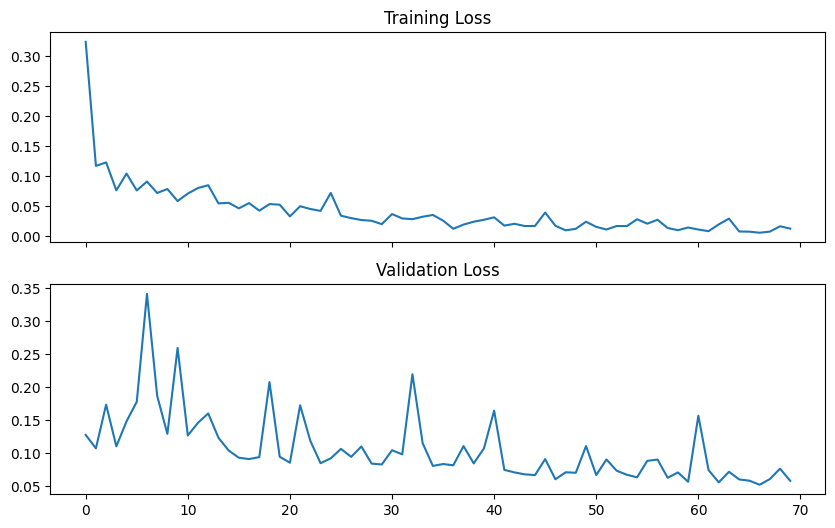

In [22]:
#Salvataggio plottato dei dati
if(model_weights == False):    
    fig, axes = plt.subplots(2, 1, sharex= True, figsize=(10, 6))
    axes[0].plot(training_loss)
    axes[0].set_title('Training Loss')
    axes[1].plot(validation_loss)
    axes[1].set_title('Validation Loss')
    plt.savefig('training_data_20000(biggan)-80-epochs.png')
    plt.show()

In [23]:
#Test
#best_test_loss = np.Inf
#test_loss = []

#testing_loss = test_fn(model, testloader, criterion)

#print(f"test_loss : {testing_loss}")

In [24]:
#QUESTA E' LA FUNZIONE PER GENERARE I VETTORI DI ENCODING
def get_encoding_csv(model, anc_img_names, dirFolder):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(dirFolder + i)
      #A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = np.expand_dims(A, 0)
      A = torch.from_numpy(A.astype(np.int32)) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc

In [25]:
#QUI RICARICO IL MODELLO UNA VOLTA TRAINATO
model.load_state_dict(torch.load('trained_model_on_20000.pt'))

#QUI CREO IL DATABASE DI FEATURE VECTORS DEL TRAINING SET
df_enc = get_encoding_csv(model, df['Anchor'], DATA_DIR)

100%|████████████████████████████████████████████████████████████████████████████| 19000/19000 [03:40<00:00, 86.09it/s]


In [26]:
#QUI IL DATABASE COME CSV IN MODO TALE DA NON DOVER FARE QUESTA OPERAZIONE OGNI VOLTA
#OVVIAMENTE, SE DEVO FARE UN NUOVO TRAINING DEVO ANCHE RICREARE GLI ENCODINGS
if(model_weights == False):
    df_enc.to_csv('database.csv', index = False)

    df_enc = pd.read_csv('database.csv')
    df_enc.head()

In [27]:
def euclidean_dist(img_enc, anc_enc_arr):
    #dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    dist = np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T)
    #dist = np.sqrt(dist)
    return dist

In [28]:
def getImageEmbeddings(img, model):

    img = np.expand_dims(img, 0)
    img = torch.from_numpy(img) / 255
    model.eval();

    with torch.no_grad():
        img = img.to(DEVICE)
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()
        img_enc = np.array(img_enc)

    return img_enc

In [29]:
def searchInDatabase(img_enc, database):
    anc_enc_arr = database.iloc[:, 1:].to_numpy()
    anc_img_names = database['Anchor']

    distance = []
    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return database['Anchor'][closest_idx[0]]

In [47]:
DataTestReal = 'test_set.csv'
test_df = pd.read_csv(DataTestReal, header = None)

In [63]:
y_true = ['fake'] * 500 + ['real'] * 500
y_pred = []

In [64]:
database = df_enc

In [65]:
def test_images(test_df, start_index, end_index, database, model):
    for index, row in tqdm(test_df.iloc[start_index:end_index].iterrows(), total=end_index-start_index):
        img_name = row[0] # Accesso diretto alla prima (e unica) colonna

        # Verifica se il nome del file è valido
        if pd.isnull(img_name) or not os.path.isfile(img_name):
            print(f"Invalid image file path at index {index}: {img_name}")
            y_pred.append("error")
            continue
        
        # Leggi e processa l'immagine
        img = io.imread(img_name)

        # Ottieni gli embeddings dell'immagine
        img_enc = getImageEmbeddings(img, model)

        # Cerca nel database
        closestLabel = searchInDatabase(img_enc, database)
 
        # Aggiungi la predizione alla lista
        if "coco" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")

In [66]:
test_images(test_df, 0, 1000, database, model)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:41<00:00,  3.55it/s]


In [67]:
print(len(y_true))
print(len(y_pred))
print(y_pred)

1000
1000
['fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake

In [69]:
#Creo i vettori di ground truth
y_true = np.array(['fake'] * 500)
print(y_true.shape)

temp = np.array(['real'] * 500)
print(temp.shape)

y_true = np.concatenate([y_true, temp])
print(y_true.shape)

#Calcolo la matrice di confusione
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=["real", "fake"])

(500,)
(500,)
(1000,)


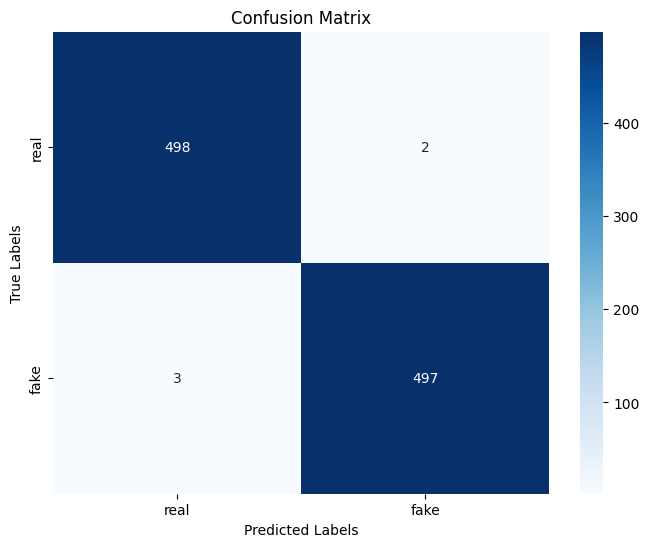

In [74]:
#Estraggo dalla matrice di confusione i True Negative, False Positive, False Negative, True Positive
TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=["real", "fake"]).ravel()

# Plotto la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["real", "fake"], yticklabels=["real", "fake"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
# Salvo l'immagine
plt.savefig('confusion_matrix_1000(biggan-coco).png')
plt.show()

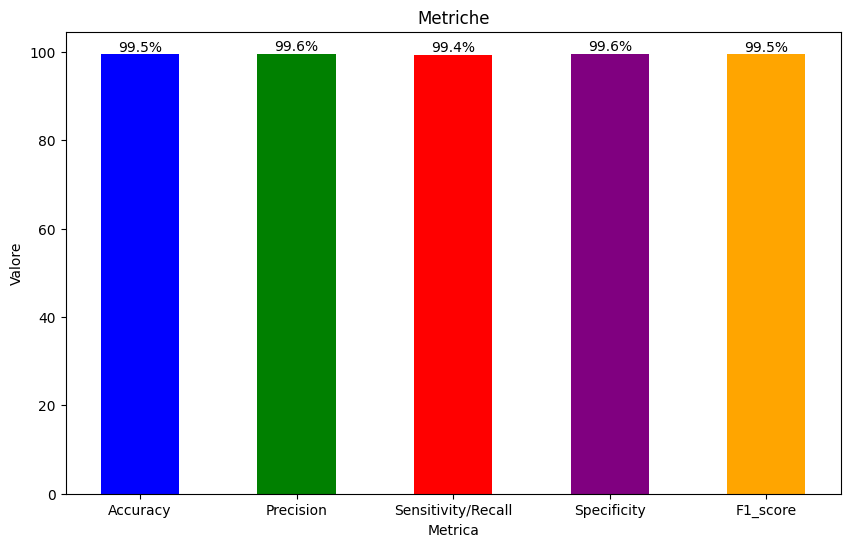

In [85]:
#Calcolo alcune metriche per vedere come si comporta
accuracy = round((TP + TN) /(TP + TN + FP + FN), 4) * 100
precision = round((TP) / (TP + FP), 4) * 100
sensitivy_recall = round((TP) / (TP + FN), 4) * 100
specificity = round((TN) / (TN + FP) * 100, 4)
F1_score = round((2* precision * sensitivy_recall) / (precision + sensitivy_recall), 2)

metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Sensitivity/Recall": sensitivy_recall,
    "Specificity": specificity,
    "F1_score": F1_score
}

# Nomi delle metriche
labels = list(metrics.keys())

# Valori delle metriche
values = list(metrics.values())

# Creazione dell'istogramma
plt.figure(figsize=(10,6))
plt.bar(labels, values, color=['blue', 'green', 'red', 'purple', 'orange'], width=0.5)

# Aggiunta delle etichette
for i in range(len(labels)):
    plt.text(i, values[i], f'{values[i]}%', ha = 'center', va = 'bottom')

# Titoli e etichette degli assi
plt.title('Metriche')
plt.xlabel('Metrica')
plt.ylabel('Valore')

plt.savefig('Metrics_with_biggan-coco.png')

# Mostra l'istogramma
plt.show()
#print({"Accuracy":accuracy,"Precision":precision,"Sensitivity_recall":sensitivy_recall, "Specificity": specificity, "F1_score":F1_score})